             Month    Buyer_Base  Sales_Saison  Sales_Surparfum  Sales_Annuel  \
0     October 2024   2438.528775      0.000000         0.000000    296.000000   
1    November 2024   4758.129098      0.000000         0.000000    123.000000   
2    December 2024   6964.601179   1199.538885         0.000000    241.133626   
3     January 2025   9063.462346      0.000000         0.000000    101.000000   
4    February 2025  11059.960846      0.000000         0.000000    127.000000   
5       March 2025  12959.088966   1655.996645       126.267251    213.157718   
6       April 2025  14765.595514      0.000000         0.000000    171.000000   
7         May 2025  16483.997698      0.000000         0.000000    270.000000   
8        June 2025  18118.592419   1909.640303       174.315436    363.507384   
9        July 2025  19673.467014      0.000000         0.000000    146.000000   
10     August 2025  21152.509481      0.000000         0.000000    112.000000   
11  September 2025  22559.41

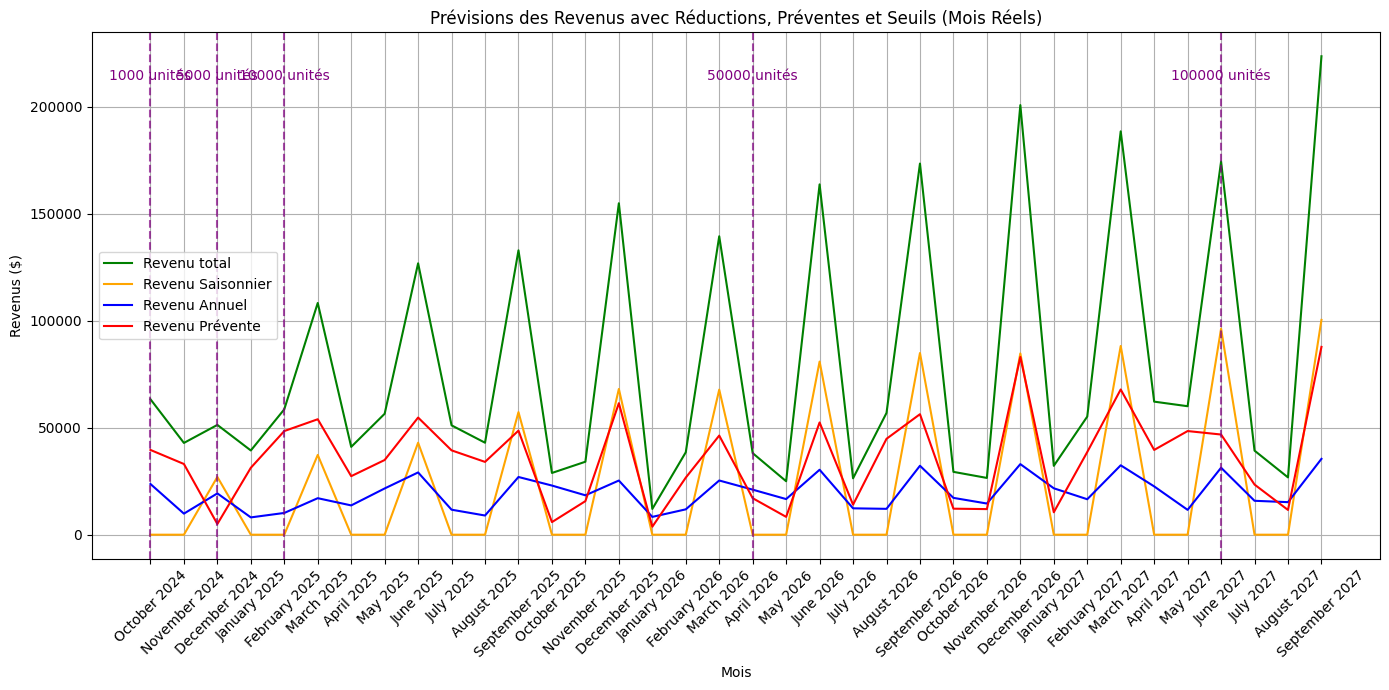

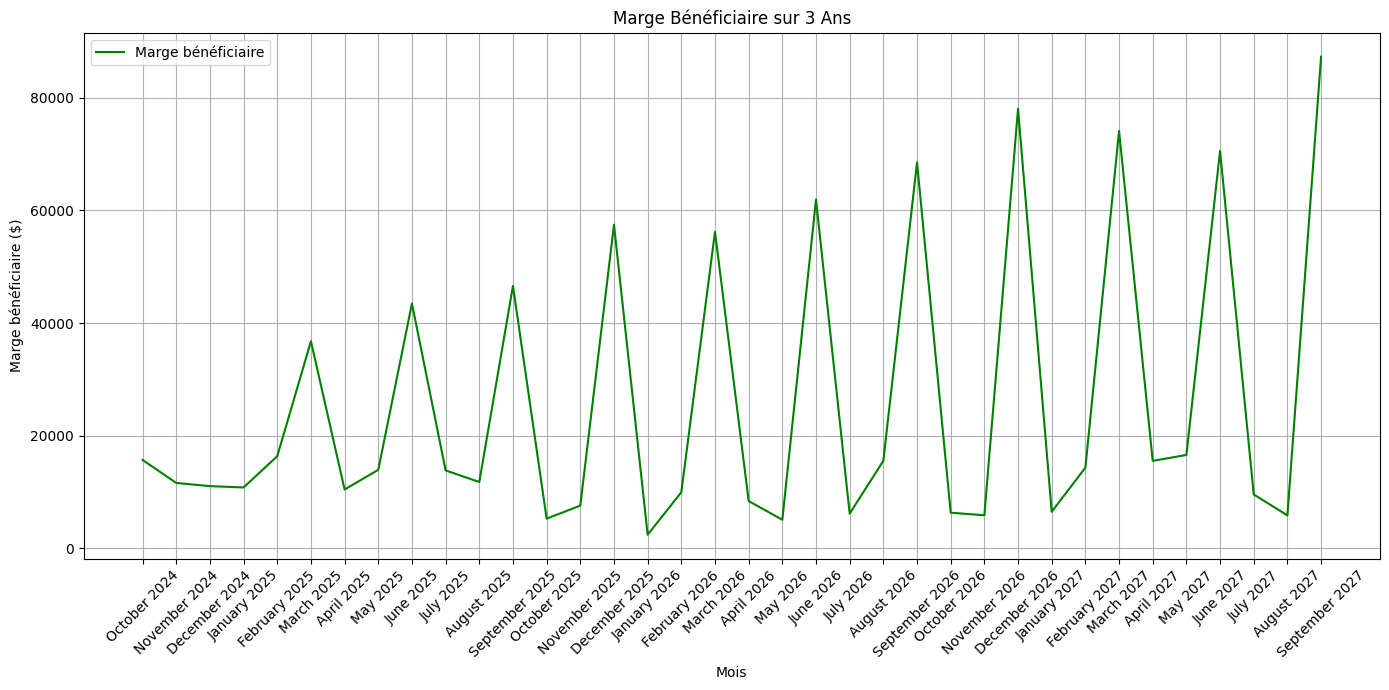

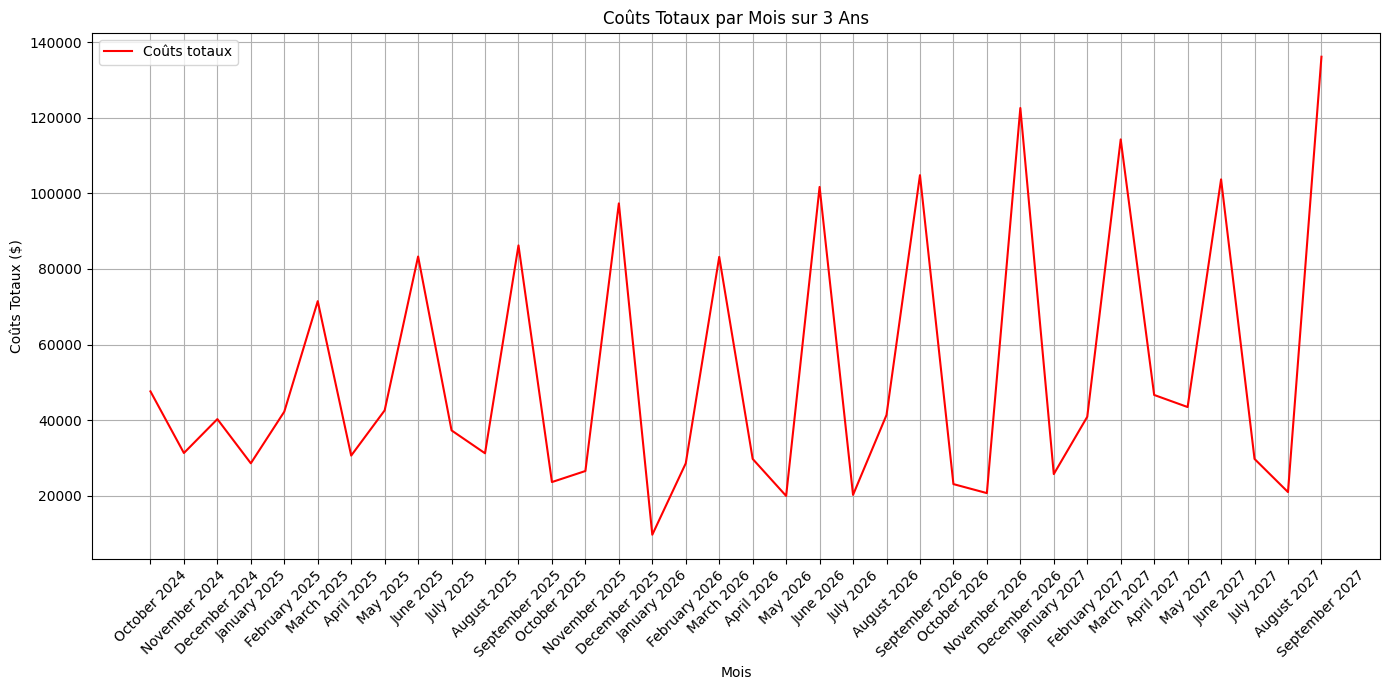

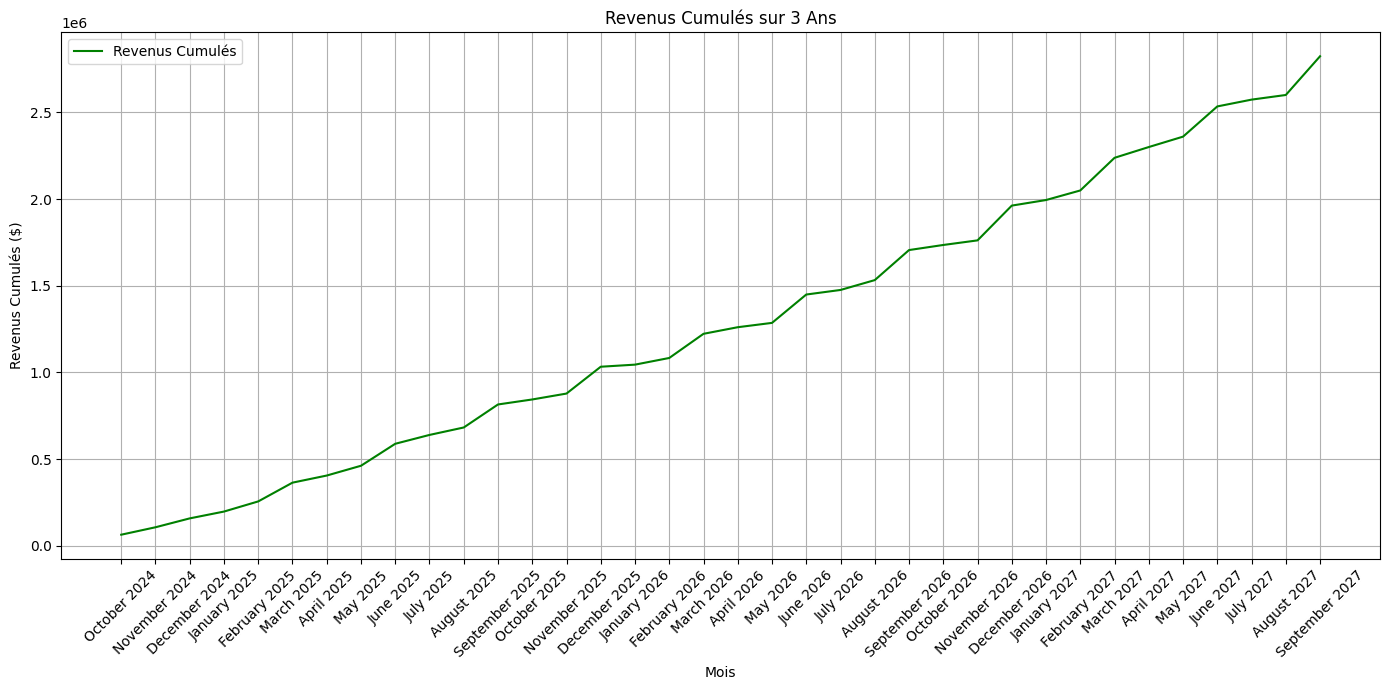

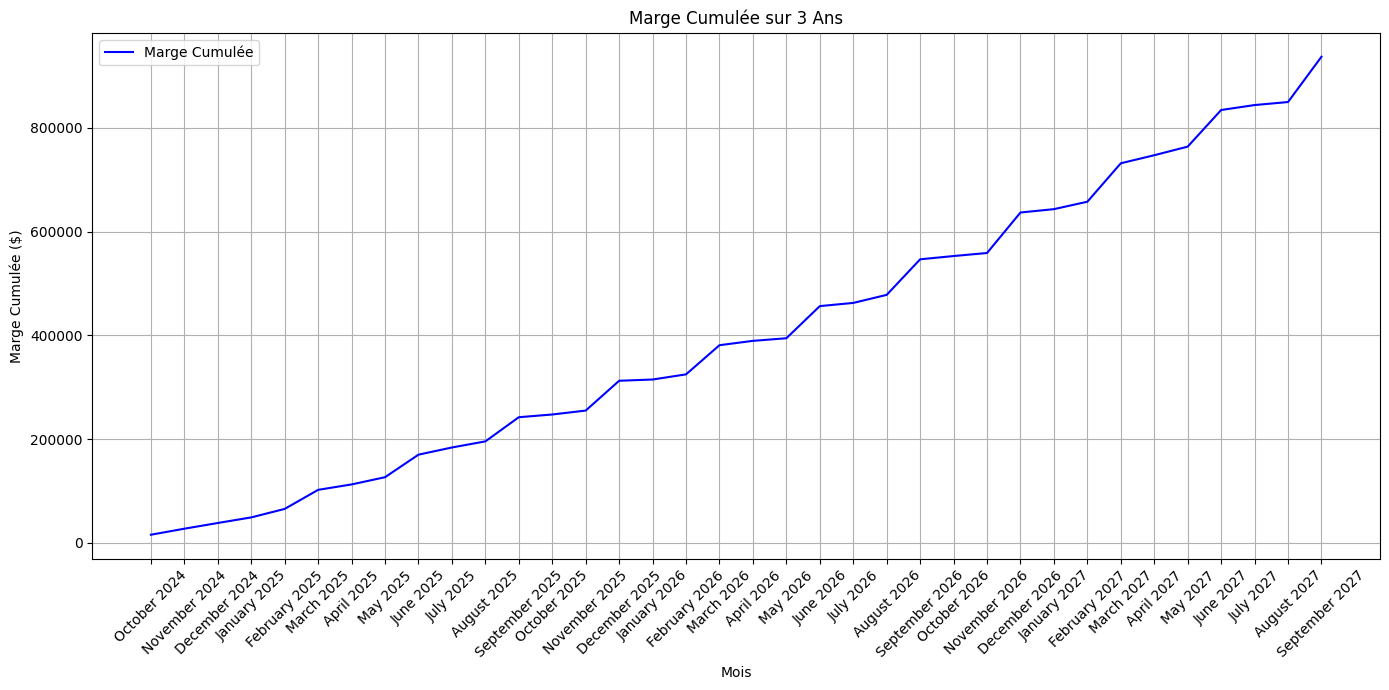

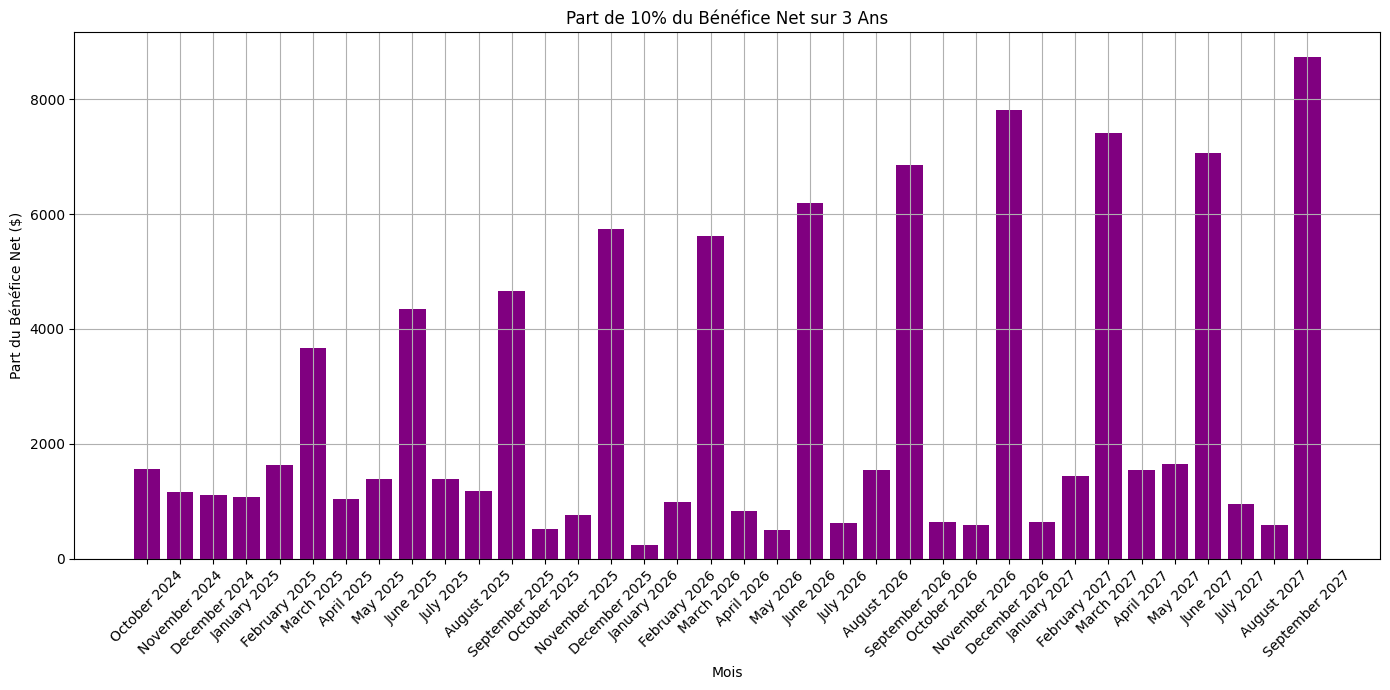

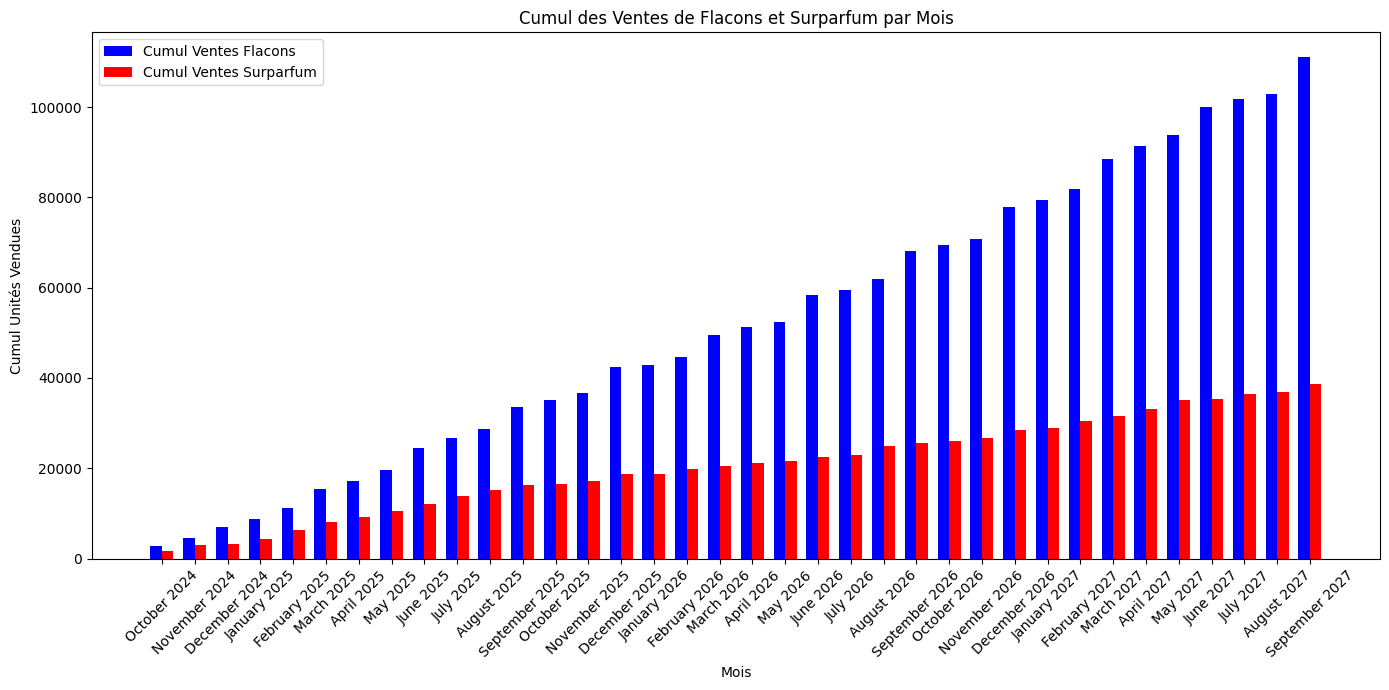

In [25]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Paramètres
price_season = 25  # Prix pour achat saisonnier
discount_season_renewal = 0.9  # Réduction de 10% pour les renouvellements saisonniers
discount_annual = 0.8  # Réduction de 20% pour l'achat annuel
price_surparfum = 98  # Prix du surparfum en prévente
churn_rate = 0.06  # 6% de churn sur les renouvellements

# Coûts
cost_acquisition = 5  # Coût d'acquisition par unité
cost_fabrication = 8  # Coût de fabrication par unité
manufacturer_cut = 4  # Coupe du fabricant par unité

# Paramètres supplémentaires
surparfum_rate = 0.10  # 10% des clients saisonniers achètent un surparfum 3 mois après
season_to_annual_conversion = 0.05  # 5% des clients saisonniers passent en annuel

# Début des ventes en octobre 2024
start_date = datetime(2024, 10, 1)
number_of_months = 36  # Nombre dynamique de mois à simuler
months = pd.date_range(start=start_date, periods=number_of_months, freq='MS').strftime("%B %Y")  # Mois réels

# Sales thresholds (objectifs de ventes à atteindre)
sales_goals = {
    '1000 unités': 1000,
    '5000 unités': 5000,
    '10000 unités': 10000,
    '50000 unités': 50000,
    '100000 unités': 100000
}

# Paramètres pour la base d'acheteurs avec croissance exponentielle inverse
B0 = 50000  # Taille maximale de la base d'acheteurs
k = 0.05  # Taux de croissance initial rapide mais ralentit

# Base d'acheteurs croissante selon un modèle exponentiel inverse
buyer_base = B0 * (1 - np.exp(-k * np.arange(1, number_of_months + 1)))

# Simulation des ventes saisonnières sur plusieurs saisons (avec churn de 6% appliqué)
sales_season = np.zeros(number_of_months)
season_months = [2, 5, 8, 11]  # Mois des saisons (mars, juin, septembre, décembre dans l'index)
for year in range(number_of_months // 12 + 1):  # Ajustement en fonction des mois dynamiques
    for month in season_months:
        index = year * 12 + month
        if index < number_of_months:
            # Appliquer 6% de churn sur la base d'acheteurs existante pour chaque cycle de renouvellement
            buyer_base_with_churn = buyer_base[index] * (1 - churn_rate)
            # 10% des acheteurs saisonniers achètent chaque saison
            sales_season[index] = float(np.random.randint(300, 800)) + buyer_base_with_churn * 0.1

# Ventes annuelles et préventes
sales_annual = np.random.randint(100, 300, size=number_of_months).astype(float)  # Simulation des ventes annuelles
sales_prevent = np.random.randint(0, 500, size=number_of_months).astype(float)  # Simulation des ventes de préventes

# Calcul des ventes de surparfum après 3 mois pour 10% des clients saisonniers
sales_surparfum = np.zeros(number_of_months, dtype=float)
for i in range(3, number_of_months):  # Surparfum acheté 3 mois après les achats saisonniers
    sales_surparfum[i] = sales_season[i - 3] * surparfum_rate

# Conversion de 5% des clients saisonniers en annuels
converted_to_annual = sales_season * season_to_annual_conversion
sales_annual += converted_to_annual  # Ajout des conversions aux ventes annuelles
sales_season -= converted_to_annual  # Retrait des conversions des ventes saisonnières

# Calcul des revenus avec réductions
revenues_season = sales_season * price_season * discount_season_renewal  # Avec rabais de 10% pour les renouvellements
revenues_annual = sales_annual * 4 * price_season * discount_annual  # Avec rabais de 20% pour les annuels
revenues_prevent = (sales_prevent + sales_surparfum) * price_surparfum  # Inclut le surparfum avec réduction

# Total revenu par mois
total_revenue = revenues_season + revenues_annual + revenues_prevent

# Calcul des coûts totaux
total_units_sold = sales_season + 4 * (sales_annual + sales_prevent)
total_costs = total_units_sold * (cost_acquisition + cost_fabrication + manufacturer_cut)

# Calcul de la marge bénéficiaire après coûts
profit_margin = total_revenue - total_costs

# Suivi des objectifs (tracking when sales goals are reached)
cumulative_sales = total_units_sold.cumsum()
goals_reached = {}
for goal_name, goal_value in sales_goals.items():
    reached_indices = np.where(cumulative_sales >= goal_value)[0]
    if len(reached_indices) > 0:
        reached_index = reached_indices[0]
        goals_reached[goal_name] = months[reached_index]

# Cumulative units sold (no stock, only sales accumulation)
cumulative_units_sold_flacons = total_units_sold.cumsum()  # Cumulative units sold (saison and annuel combined)
cumulative_units_sold_preventes = (4 * sales_prevent).cumsum()  # Cumulative units sold for surparfum pre-sales


# Création d'un DataFrame pour tout afficher avec des dates réelles
df = pd.DataFrame({
    'Month': months,
    'Buyer_Base': buyer_base,
    'Sales_Saison': sales_season,
    'Sales_Surparfum': sales_surparfum,
    'Sales_Annuel': sales_annual,
    'Sales_Prevente': sales_prevent,
    'Revenu_Saison': revenues_season,
    'Revenu_Annuel': revenues_annual,
    'Revenu_Prevente': revenues_prevent,
    'Total_Revenu': total_revenue,
    'Total_Costs': total_costs,
    'Profit_Margin': profit_margin,
    'Cumulative_Sold_Flacons': cumulative_units_sold_flacons,
    'Cumulative_Sold_Preventes': cumulative_units_sold_preventes
})

# Affichage du DataFrame
print(df)

# Afficher les objectifs atteints
print("\nObjectifs atteints :")
for goal, month in goals_reached.items():
    print(f"{goal} atteint en {month}")

# Visualisation des résultats avec dates réelles

# 1. Prévisions des Revenus
plt.figure(figsize=(14, 7))
plt.plot(df['Month'], df['Total_Revenu'], label="Revenu total", color='green')
plt.plot(df['Month'], df['Revenu_Saison'], label="Revenu Saisonnier", color='orange')
plt.plot(df['Month'], df['Revenu_Annuel'], label="Revenu Annuel", color='blue')
plt.plot(df['Month'], df['Revenu_Prevente'], label="Revenu Prévente", color='red')

# Indicateurs des seuils avec mois réels
for goal, month in goals_reached.items():
    plt.axvline(x=month, color='purple', linestyle='--', alpha=0.7)
    plt.text(month, df['Total_Revenu'].max() * 0.95, f"{goal}", color='purple', fontsize=10, ha='center')

plt.title("Prévisions des Revenus avec Réductions, Préventes et Seuils (Mois Réels)")
plt.xlabel("Mois")
plt.xticks(rotation=45)
plt.ylabel("Revenus ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 3. Marge Bénéficiaire
plt.figure(figsize=(14, 7))
plt.plot(df['Month'], df['Profit_Margin'], label="Marge bénéficiaire", color='green')

plt.title("Marge Bénéficiaire sur 3 Ans")
plt.xlabel("Mois")
plt.xticks(rotation=45)
plt.ylabel("Marge bénéficiaire ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Coûts Totaux par Mois
plt.figure(figsize=(14, 7))
plt.plot(df['Month'], df['Total_Costs'], label="Coûts totaux", color='red')

plt.title("Coûts Totaux par Mois sur 3 Ans")
plt.xlabel("Mois")
plt.xticks(rotation=45)
plt.ylabel("Coûts Totaux ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Revenus Cumulés
plt.figure(figsize=(14, 7))
plt.plot(df['Month'], df['Total_Revenu'].cumsum(), label="Revenus Cumulés", color='green')

plt.title("Revenus Cumulés sur 3 Ans")
plt.xlabel("Mois")
plt.xticks(rotation=45)
plt.ylabel("Revenus Cumulés ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Marges Cumulées
plt.figure(figsize=(14, 7))
plt.plot(df['Month'], df['Profit_Margin'].cumsum(), label="Marge Cumulée", color='blue')

plt.title("Marge Cumulée sur 3 Ans")
plt.xlabel("Mois")
plt.xticks(rotation=45)
plt.ylabel("Marge Cumulée ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Part de Bénéfice Net (10%)
net_profit_share = df['Profit_Margin'] * 0.10
df['Net_Profit_Share'] = net_profit_share

plt.figure(figsize=(14, 7))
plt.bar(df['Month'], df['Net_Profit_Share'], color='purple')

plt.title("Part de 10% du Bénéfice Net sur 3 Ans")
plt.xlabel("Mois")
plt.xticks(rotation=45)
plt.ylabel("Part du Bénéfice Net ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Creating a grouped bar chart for cumulative units sold (flacons and pre-sales)
plt.figure(figsize=(14, 7))

bar_width = 0.35
index = np.arange(len(df['Month']))

# Bar chart for cumulative units sold
plt.bar(index, df['Cumulative_Sold_Flacons'], bar_width, label="Cumul Ventes Flacons", color='blue')
plt.bar(index + bar_width, df['Cumulative_Sold_Preventes'], bar_width, label="Cumul Ventes Surparfum", color='red')

# Adding labels and title
plt.xlabel('Mois')
plt.ylabel('Cumul Unités Vendues')
plt.title('Cumul des Ventes de Flacons et Surparfum par Mois')
plt.xticks(index + bar_width / 2, df['Month'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()



             Month            MRR           ARR
0     October 2024   23680.000000  2.841600e+05
1    November 2024    9840.000000  1.180800e+05
2    December 2024   46280.314962  5.553638e+05
3     January 2025    8080.000000  9.696000e+04
4    February 2025   10160.000000  1.219200e+05
5       March 2025   54312.541956  6.517505e+05
6       April 2025   13680.000000  1.641600e+05
7         May 2025   21600.000000  2.592000e+05
8        June 2025   72047.497567  8.645700e+05
9        July 2025   11680.000000  1.401600e+05
10     August 2025    8960.000000  1.075200e+05
11  September 2025   84209.102250  1.010509e+06
12    October 2025   22960.000000  2.755200e+05
13   November 2025   18400.000000  2.208000e+05
14   December 2025   93376.259004  1.120515e+06
15    January 2026    8320.000000  9.984000e+04
16   February 2026   11840.000000  1.420800e+05
17      March 2026   93081.860955  1.116982e+06
18      April 2026   21040.000000  2.524800e+05
19        May 2026   16640.000000  1.996

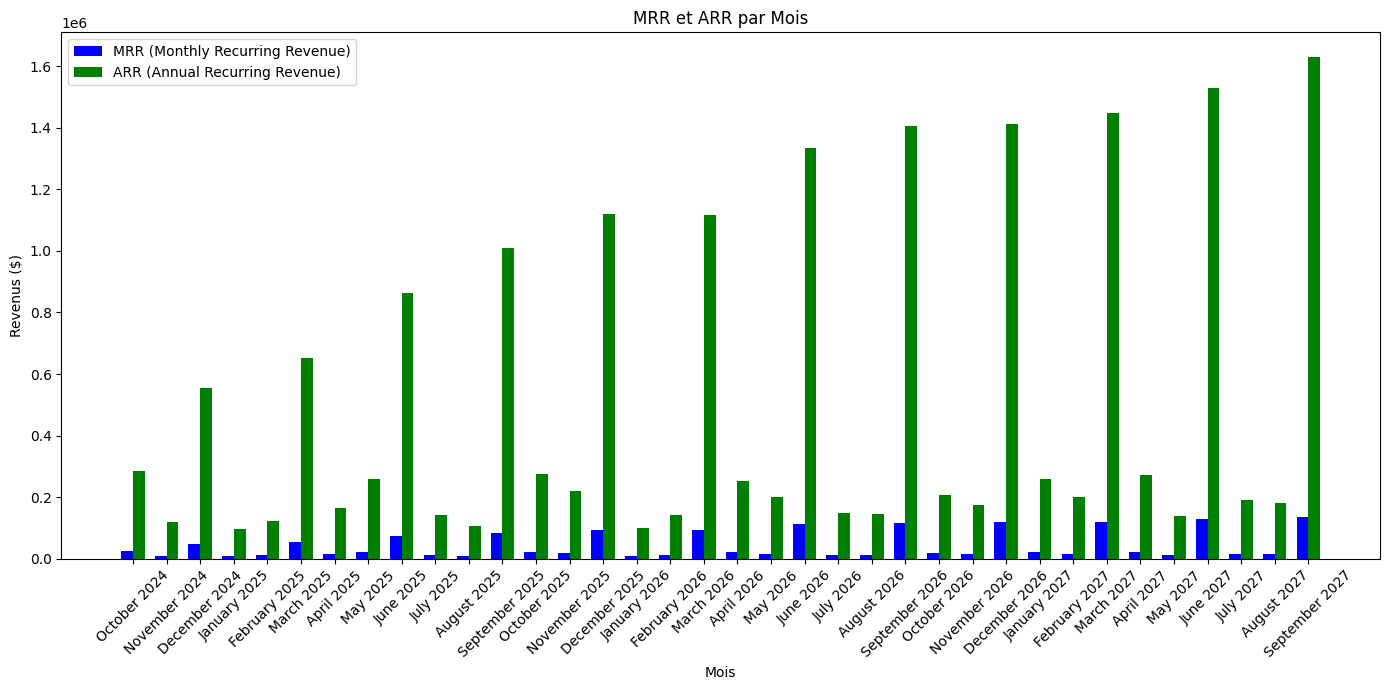

In [26]:
# Calcul du MRR (Monthly Recurring Revenue)
MRR = revenues_season + revenues_annual  # Revenus récurrents mensuels (saisonniers et annuels)

# Calcul de l'ARR (Annual Recurring Revenue) comme MRR * 12
ARR = MRR * 12

# Ajout des calculs MRR et ARR dans le DataFrame
df['MRR'] = MRR
df['ARR'] = ARR

# Affichage du DataFrame avec MRR et ARR
print(df[['Month', 'MRR', 'ARR']])

# Création d'un bar chart pour MRR et ARR
plt.figure(figsize=(14, 7))

bar_width = 0.35
index = np.arange(len(df['Month']))

# Bar chart pour MRR et ARR
plt.bar(index, df['MRR'], bar_width, label="MRR (Monthly Recurring Revenue)", color='blue')
plt.bar(index + bar_width, df['ARR'], bar_width, label="ARR (Annual Recurring Revenue)", color='green')

# Ajout des labels et titre
plt.xlabel('Mois')
plt.ylabel('Revenus ($)')
plt.title('MRR et ARR par Mois')
plt.xticks(index + bar_width / 2, df['Month'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


             Month    New_Users     Old_Users  Churned_Users  Cumulative_Users
0     October 2024   243.852877      0.000000       0.000000        243.852877
1    November 2024   475.812910    229.221705      14.631173        705.034615
2    December 2024   696.460118    662.732538      42.302077       1359.192656
3     January 2025   906.346235   1277.641096      81.551559       2183.987331
4    February 2025  1105.996085   2052.948091     131.039240       3158.944176
5       March 2025  1295.908897   2969.407525     189.536651       4265.316422
6       April 2025  1476.559551   4009.397436     255.918985       5485.956988
7         May 2025  1648.399770   5156.799569     329.157419       6805.199338
8        June 2025  1811.859242   6396.887378     408.311960       8208.746620
9        July 2025  1967.346701   7716.221823     492.524797       9683.568524
10     August 2025  2115.250948   9102.554413     581.014111      11217.805361
11  September 2025  2255.941820  10544.737039     67

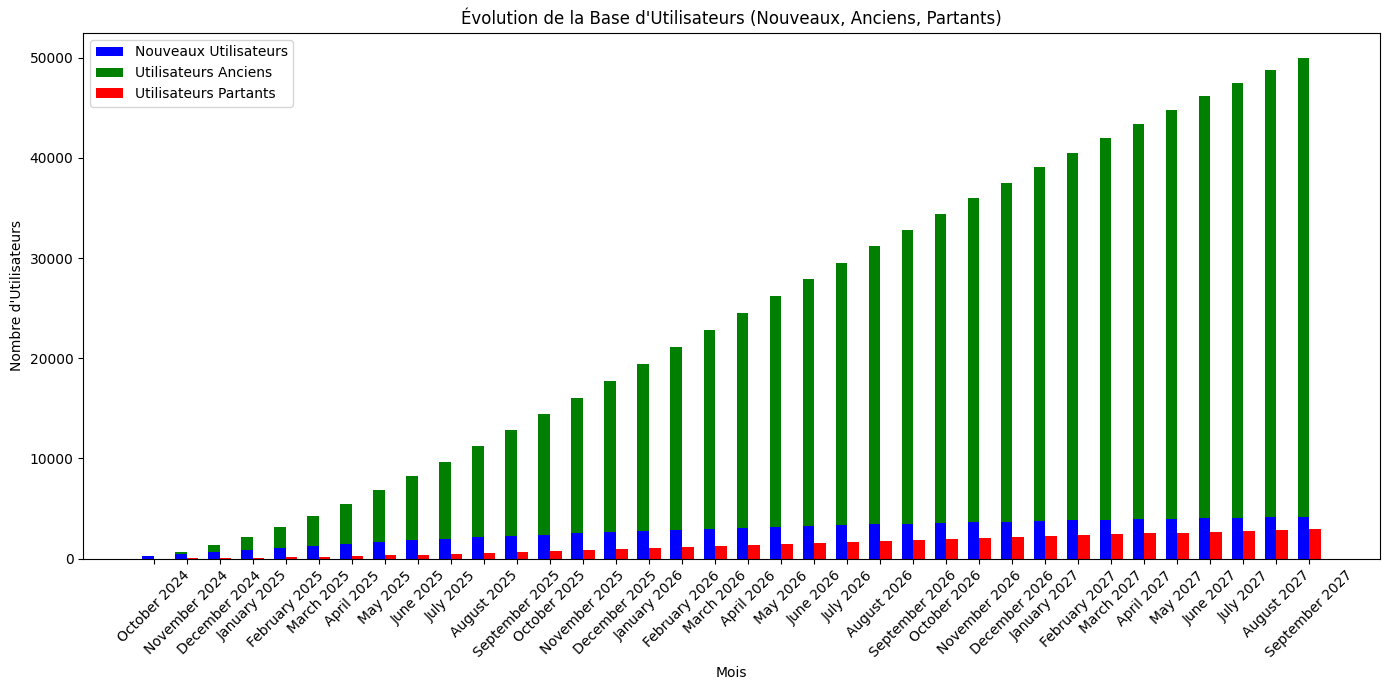

In [27]:
# Paramètres de la base d'utilisateurs
new_users = np.zeros(number_of_months)  # Nouveaux utilisateurs chaque mois
old_users = np.zeros(number_of_months)  # Utilisateurs récurrents chaque mois
churned_users = np.zeros(number_of_months)  # Utilisateurs ayant quitté chaque mois
cumulative_users = np.zeros(number_of_months)  # Utilisateurs cumulés chaque mois

# Initialisation de la base d'utilisateurs
new_users[0] = buyer_base[0] * 0.1  # 10% du buyer_base sont de nouveaux utilisateurs au premier mois
cumulative_users[0] = new_users[0]  # Les utilisateurs cumulés commencent avec les nouveaux

for i in range(1, number_of_months):
    # Nouveaux utilisateurs chaque mois (10% de la base d'acheteurs potentiels)
    new_users[i] = buyer_base[i] * 0.1

    # Utilisateurs récurrents (base utilisateurs précédente avec churn de 6%)
    old_users[i] = cumulative_users[i - 1] * (1 - churn_rate)

    # Calcul des utilisateurs perdus à cause du churn
    churned_users[i] = cumulative_users[i - 1] * churn_rate

    # Mise à jour de la base d'utilisateurs cumulée
    cumulative_users[i] = old_users[i] + new_users[i]

# Ajout des données utilisateur dans le DataFrame
df['New_Users'] = new_users
df['Old_Users'] = old_users
df['Churned_Users'] = churned_users
df['Cumulative_Users'] = cumulative_users

# Affichage du DataFrame avec les données utilisateur
print(df[['Month', 'New_Users', 'Old_Users', 'Churned_Users', 'Cumulative_Users']])
# Création d'un bar chart pour visualiser l'évolution de la base d'utilisateurs avec utilisateurs partants
plt.figure(figsize=(14, 7))

bar_width = 0.35
index = np.arange(len(df['Month']))

# Bar chart empilé pour nouveaux, anciens et churnés utilisateurs
plt.bar(index, df['New_Users'], bar_width, label="Nouveaux Utilisateurs", color='blue')
plt.bar(index, df['Old_Users'], bar_width, bottom=df['New_Users'], label="Utilisateurs Anciens", color='green')
plt.bar(index + bar_width, df['Churned_Users'], bar_width, label="Utilisateurs Partants", color='red')

# Ajout des labels et titre
plt.xlabel('Mois')
plt.ylabel('Nombre d\'Utilisateurs')
plt.title('Évolution de la Base d\'Utilisateurs (Nouveaux, Anciens, Partants)')
plt.xticks(index + bar_width / 2, df['Month'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()
# Création d'un bar chart empilé pour visualiser l'évolution de la base d'utilisateu

